In [1]:
import level1,level2,analysis,plottools,inversions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import datetime as dt
import scipy.stats as stats
import numpy.ma as ma
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as sciopt
import matplotlib.tri as tri

In [2]:
# Data
eddies = np.load('../../eddies_last.npy').item()
ADCPs = np.load('../../ADCPS.npy').item()

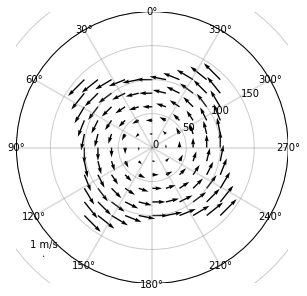

In [3]:
#simulate a whole eddy
xm = np.arange(-100000,101000,20000)
ym = np.arange(-100000,101000,20000)
X,Y = np.meshgrid(xm,ym)
xc = 0
yc = 0
U,V = inversions.Simulate(xc,yc,X,Y,omega=1e-5,fmt='UV')
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
plottools.Hodograph(ax,200,xtext=False,ytext=False,grid=50)
# Set axis limits, in order to see circle aspect MUST be set to equal
#ax.set_xlim(-200,200)
#ax.set_ylim(-200,200)
ax.set_aspect('equal')

Q=plt.quiver(xm/1000,ym/1000,U,V,width=0.005,pivot='tail')
plt.quiverkey(Q,0.1,0.1,0.01,label= '1 m/s')
plt.show()

A filter should be applied directly to the data with 3 dimensions

In [8]:
eddy = 'M12'
U_filt = eddies[eddy]['U reg filt']
V_filt = eddies[eddy]['V reg filt']
U = eddies[eddy]['U']
V = eddies[eddy]['V']
atd_reg = eddies[eddy]['ATD reg']
atd = eddies[eddy]['ATD']
depths = eddies[eddy]['depths']
lon = eddies[eddy]['longitudes']
lat = eddies[eddy]['latitudes']
deltat = 100

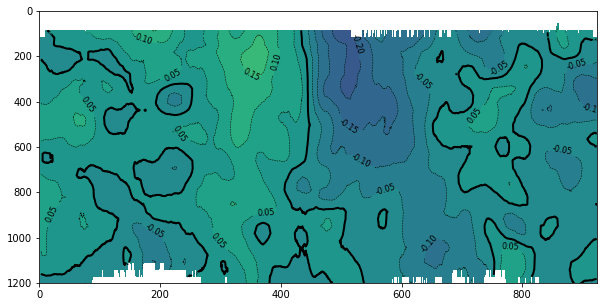

In [9]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(1200,0)
plottools.PlotADCP(ax,atd_reg/1000,depths,V_filt)
# X,Z = np.meshgrid(atd_reg,depths)
# ax.contourf(X,Z,np.transpose(V_filt))
plt.show()

In [10]:
m = Basemap(projection='merc',llcrnrlat = min(lat)-1,urcrnrlat = max(lat)+1,llcrnrlon=min(lon)-1,urcrnrlon=max(lon)+1)
x,y = m(lon,lat)

## Find the center

## Refine to a more or less solid body rotation (SBR) area
Here we use the data that was filtered from atd axis, just to somehow extract the area where the eddy is in solid body rotation. But keep in mind that this process would be precise only if the ship track was perfectly zonal, which is not always the case, so one should select a quite low threshold of correlation.  
A huge problem here is that we want the filtered data but placed on the right points, ie no filter on atd axis is possible. We therefore use a filter that does everything in the 3D space

In [16]:
V_filt2 = analysis.BoxCarFilter2(V,x,y,depths,40e3,40e3,75)
U_filt2 = analysis.BoxCarFilter2(U,x,y,depths,40e3,40e3,75)

/home/affholder/Documents/Stage/Araujo/Eddie_Tracks/Scripts/ADCP/analysis.py:231: RuntimeWarning: Mean of empty slice
  val = np.nanmean(Mf[indexes])


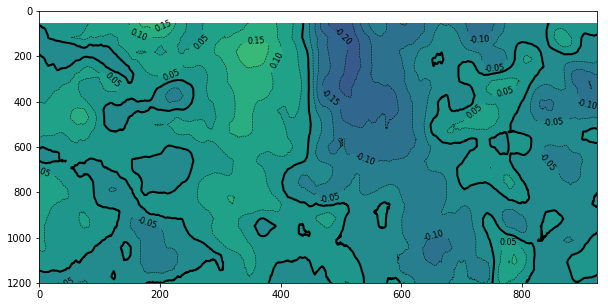

In [43]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(1200,0)
plottools.PlotADCP(ax,atd/1000,depths,V_filt2)
# X,Z = np.meshgrid(atd_reg,depths)
# ax.contourf(X,Z,np.transpose(V_filt))
plt.show()

In [20]:
faisceau,ZZ2,Rvals,Pvals=inversions.SolidBodyCorrelation(U_filt2,V_filt2,atd,depths,sizemax=200e3)

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


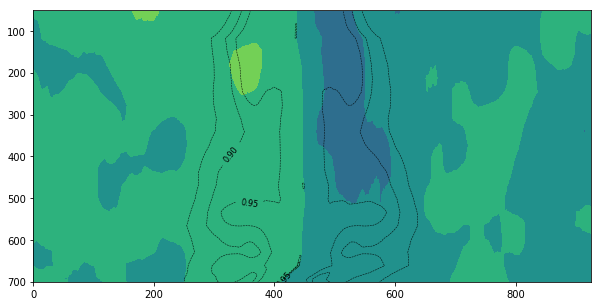

In [23]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(700,50)
XX,ZZ = np.meshgrid(atd/1000,depths)
ax.contourf(XX,ZZ,np.transpose(V_filt2))
# ax.plot(Zeros/1000,depths,'k--',linewidth = 1.5)
levels = [0.8,0.9,0.95]
cont = ax.contour(faisceau/1000,ZZ2,Rvals,linestyles='dashed',colors='k',linewidths=0.5,levels=levels)
ax.clabel(cont, fontsize=8, inline=1, fmt='%1.2f')
# ax.plot(faisceau[np.where(Pvals_sim>0.05)]/1000,ZZ2[np.where(Pvals_sim>0.05)],'k+',ms=2)
plt.show()

In [37]:
## Select data within the threshold
indexes = inversions.SBRCindex(Rvals,atd,faisceau,depths,thresh=0.6)

/home/affholder/Documents/Stage/Araujo/Eddie_Tracks/Scripts/ADCP/inversions.py:258: RuntimeWarning: invalid value encountered in greater
  faisc = faisceau[i,Rvals[i,:] > thresh]


In [38]:
mask = np.zeros((V_filt2.shape[0],V_filt2.shape[1]))
mask[indexes] = 1
mask = mask == 1
V_filt_masked = np.ma.array(V_filt2,mask=mask)
U_filt_masked = np.ma.array(U_filt2,mask=mask)

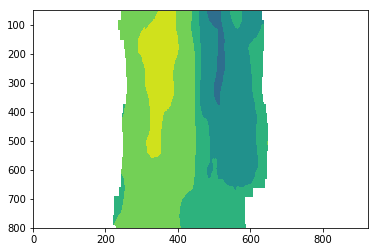

In [39]:
# XX,ZZ = np.meshgrid(atd_reg/1000,depths)
plt.ylim(800,50)
plt.contourf(XX,ZZ,np.transpose(V_filt_masked))
plt.show()

In [40]:
## Get the orientations of velocities to fit the best center
angles_m = np.angle(U_filt2 + V_filt2*1j)
cos_m = np.cos(angles_m)
sin_m = np.sin(angles_m)
angles_m_msk = np.ma.array(angles_m,mask=mask)
cos_m_msk = np.ma.array(cos_m,mask=mask)
sin_m_msk = np.ma.array(sin_m,mask=mask)

In [44]:
## Mapping the error
xplore = np.arange(400,700,1)*1e3
yplore = np.arange(150,400,1)*1e3
Merr = inversions.MapError(xplore,yplore,x,y,cos_m[:,15],sin_m[:,15],mask=mask[:,15])

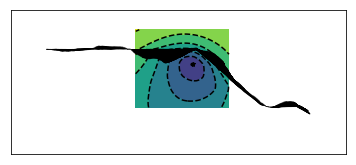

In [45]:
Xp,Yp = np.meshgrid(xplore,yplore)
M = np.transpose(Merr)
# plt.plot(x,y)
plt.contourf(Xp,Yp,M)
cont = plt.contour(Xp,Yp,M,linestyles='dashed',colors='k')
m.plot(Xp[M==np.nanmin(M)],Yp[M==np.nanmin(M)],'k*',ms=5)

m.quiver(x,y,U_filt_masked[:,15],V_filt_masked[:,3],pivot='tail',scale=5)
m.quiver(x,y,U_filt[:,15],V_filt[:,15],pivot='tail',alpha=0.5,scale=5)
plt.show()

In [46]:
Xvc = []
Yvc = []
deltat = 10
for i in range(len(depths)):
    vm = V_filt[:,i]
    if np.sum(np.isnan(vm)) == len(vm):
        xvc = np.nan
        yvc = np.nan
    else :
        vmint = np.nancumsum(vm)*deltat
        vc = np.nanmax(vmint)
        index = np.where(vmint == vc)[0]
        if len(index)>1:
            index = index[0]
        xvc = x[index]
        yvc = y[index]
    Xvc.append(xvc)
    Yvc.append(yvc)
Xvc = np.array(Xvc)
Yvc = np.array(Yvc)

In [48]:
Xc = []
Yc = []
Er = []
S = []
for i in range(len(depths)):
    msk = ~mask[:,i]
    res = sciopt.minimize(fun = inversions.AngularError,
                          x0=[Xvc[i],Yvc[i]],args=(x[msk],y[msk],cos_m[msk,i],sin_m[msk,i]),
                          method='Powell',tol=1e-8)
    xc = res['x'][0]
    yc = res['x'][1]
    rr = res['fun']
    s = res['success']
    Xc.append(xc)
    Yc.append(yc)
    Er.append(rr)
    S.append(s)
Xc = np.array(Xc)
Yc = np.array(Yc)
Er = np.array(Er)
S = np.array(S)
    

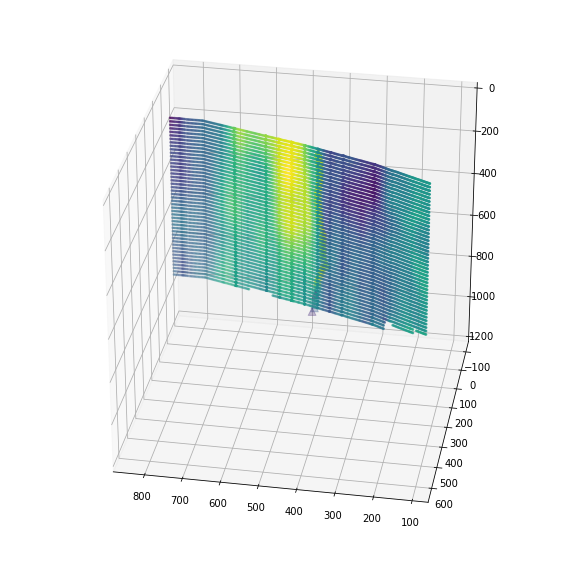

In [29]:
X = []
Y = []
Z = []
# Vl = []
for i in range(len(x)):
    for j in range(len(depths)):
        X.append(x[i])
        Y.append(y[i])
        Z.append(depths[j])
#         Vl.append(V[i,j])
X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
# Vl = np.array(Vl)
Vlf = V_filt.flatten()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
# ax.set_yticks(np.arange(100,250,10))
# ax.set_xticks(np.arange(100,700,10))
# ax.set_xlim(100,700)
# ax.set_ylim(100,250)
ax.set_zlim(1200,0)
sc = ax.scatter(X/1000,Y/1000,Z,c=Vlf,s=3)
sc2 = ax.scatter(Xc/1000,Yc/1000,depths,s=60,marker='^',c=Er)
# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([X.max()-X.min(), Y.max()-Y.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb in zip(Xb, Yb):
    ax.plot([xb/1000], [yb/1000], [0], 'w')
ax.view_init(30,100)

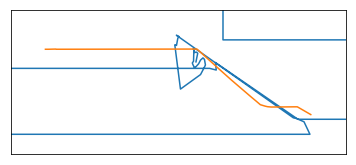

In [49]:
m.plot(Xc,Yc)
m.plot(x,y)

(0, 2000)

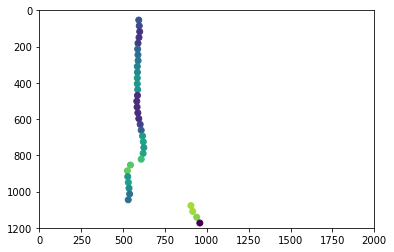

In [50]:
plt.scatter(Xc/1000,depths,c=Er)
plt.ylim(1200,0)
plt.xlim(0,2000)

In [29]:
## Now project everything on the cylinder

In [74]:
Ur = np.zeros((len(x),len(depths)))
Vr = np.zeros((len(x),len(depths)))
R = np.zeros((len(x),len(depths)))
R2 = np.zeros((len(x),len(depths)))
for i in range(len(depths)):
    xc = Xc[i]
    yc = Yc[i]
    if np.isfinite(xc):
        v = V_filt2[:,i]
        u = U_filt2[:,i]
        r = np.sqrt((x-xc)**2 + (y - yc)**2)
        r2 = np.sign(x-xc)*np.sqrt((x-xc)**2 + (y - yc)**2)
        angles = np.angle((x - xc) + (y - yc)*1j,deg=False)
        num = np.isfinite(u)
        for j in range(len(angles)):
            if num[j]:
                theta = angles[j]
                uri,vri = level2.Rotation([u[j]],[v[j]],theta,[0,0])
            else:
                uri = np.nan
                vri = np.nan
            Ur[j,i] = uri
            Vr[j,i] = vri
    else:
        Ur[:,i] = np.full(len(angles),np.nan)
        Vr[:,i] = np.full(len(angles),np.nan)
    R[:,i] = r
    R2[:,i] = r2

#omegas = 

In [75]:
Zeta  =2*np.angle(R + Vr*1j)

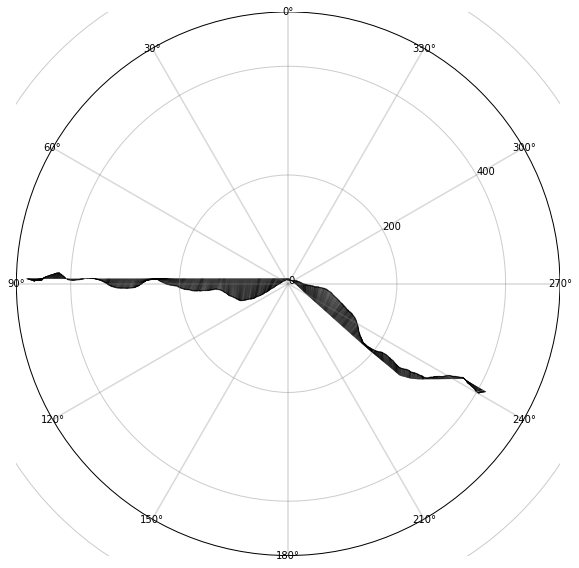

In [76]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1)
angles = np.angle((x - Xc[3]) + (y - Yc[3])*1j,deg=False)
plottools.Hodograph(ax,500,xtext=False,ytext=False,grid=200)
ax.quiver(R[:,3]/1000*np.cos(angles),R[:,3]/1000*np.sin(angles),U_filt[:,3],V_filt[:,3],scale=5,width=0.0005)
plt.show()

In [77]:
X = []
Y = []
Z = []
for i in range(len(x)):
    for j in range(len(depths)):
        X.append(atd[i])
        Z.append(depths[j])
X = np.array(X)
Z = np.array(Z)
Zetaf = Zeta.flatten()
# Regular grid
xi = np.linspace(min(atd),max(atd), len(x))
zi = np.linspace(min(depths), max(depths), len(depths))
# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(X, Z)
interpolator = tri.LinearTriInterpolator(triang, Zetaf)
Xi, Zi = np.meshgrid(xi, zi)
zetai = interpolator(Xi, Zi)

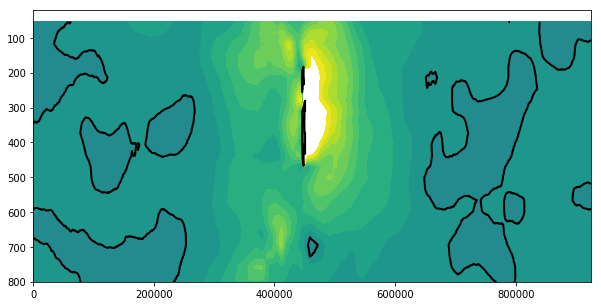

In [81]:


fig = plt.figure(figsize = (10,5))
# lvls = [-5e-6,0,1e-6,5e-6,1e-5,1.5e-5,3e-5]
lvls = np.arange(-1e-5,1e-5,1e-6)
ax = fig.add_subplot(1,1,1)
ax.set_ylim(800,20)
ax.contourf(Xi,Zi,zetai,levels=lvls)
ax.contour(Xi,Zi,zetai,levels=[0],colors='k',linewidths=2)